https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py

In [1]:
import torch
import lightning as pl
# all nn libraries nn.layer, convs and loss functions
import os
os.chdir("/home/matrament/studia/deep_learning/DeepLearning")
import torch.nn as nn
from utils import ResNet, Bottleneck 
from torch.utils.data import Dataset
from torchvision.transforms import v2
# visualisation
import torchvision
from lightning.pytorch import seed_everything
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint
from lightning.pytorch.loggers import MLFlowLogger
seed_everything(42)
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

Seed set to 42


In [2]:
class ResnetModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=10)
        self.loss = nn.BCEWithLogitsLoss()

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat, y)
        # Logging to TensorBoard (if installed) by default
        self.log("loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat, y)
        # Logging to TensorBoard (if installed) by default
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def forward(self, x):
        y = self.model(x)

        return y

In [3]:
from pycocotools.coco import COCO
class CocoDataset(Dataset):
    def __init__(self):
        super().__init__()
        self.transform =  v2.Compose([
            v2.ToImage(),
            v2.RandomResizedCrop(size=(100, 100), antialias=True),
            v2.RandomHorizontalFlip(p=0.5),
            v2.ToDtype(torch.float32, scale=True),
        ])     
        self.normalization=v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.coco = torchvision.datasets.CocoDetection(
            root="dataset/train2017_subset",
            annFile="dataset/instances_train2017_subset.json",
            # target_transform=self.transform
        )
        self.coco_ann= COCO("dataset/instances_train2017_subset.json")
        self.cat_ids = self.coco_ann.getCatIds()
    def __len__(self):
        return len(self.coco)

    def __getitem__(self, idx):
        img_id =self.coco[idx][1][0]['image_id']
        anns_ids = self.coco_ann.getAnnIds(imgIds=img_id, catIds=self.cat_ids)
        anns = self.coco_ann.loadAnns(anns_ids)
        mask = np.zeros((self.coco[idx][0].size[1],self.coco[idx][0].size[0]))
        for ann in anns:
            mask += self.coco_ann.annToMask(ann)
        img,mask = self.transform(self.coco[idx][0],mask)
        return self.normalization(img), mask

In [4]:
class MetricTracker(pl.Callback):

    def __init__(self):
        self.collection = []

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        vacc = outputs["val_loss"]  # you can access them here
        self.collection.append(vacc)  # track them

    def on_validation_epoch_end(self, trainer, module):
        elogs = trainer.logged_metrics["val_loss"]  # access it here
        self.collection.append(elogs)
        # do whatever is needed

In [5]:
dataset_train=CocoDataset()


loading annotations into memory...
Done (t=1.34s)
creating index...
index created!
loading annotations into memory...
Done (t=1.29s)
creating index...
index created!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0605361].


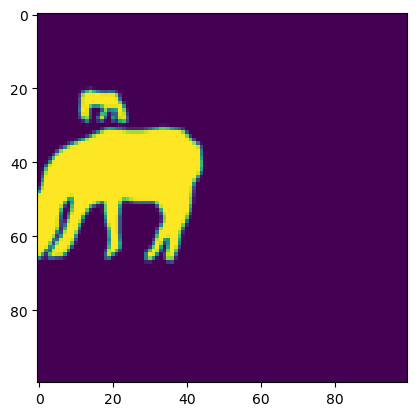

In [6]:
plt.imshow(dataset_train[-1][0].permute(1, 2, 0))
plt.imshow(dataset_train[-1][1].permute(1, 2, 0))

In [7]:
mlf_logger = MLFlowLogger(
            experiment_name=f"{'first'}_resnet",
            tracking_uri="http://localhost:5000",
            log_model=True,
        )
# torch.set_float32_matmul_precision( 'high')
metr = MetricTracker()
resnet = ResnetModule()
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=64, shuffle=True)
trainer = pl.Trainer(
    max_epochs=30,
    enable_progress_bar=True,
    logger=mlf_logger,
    default_root_dir=f"/tmp/{'v'}_{74}",
    callbacks=[
        # EarlyStopping(monitor="val_loss", mode="min", patience=7),
        # ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min"),
        metr,
    ],
)
trainer.fit(
            model=resnet, train_dataloaders=train_loader #, val_dataloaders=val_loader
        )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/matrament/.local/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | ResNet            | 44.0 M | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
44.0 M    Trainable params
0         Non-trainable params
44.0 M    Total params
175.952   Total estimated model params size (MB)
152       Modules in train mode
0         Modules in eval mode
/home/matrament/.local/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_

Epoch 0:   2%|▏         | 6/375 [00:49<50:32,  0.12it/s, v_num=40ef]


Detected KeyboardInterrupt, attempting graceful shutdown ...


🏃 View run efficient-bird-538 at: http://localhost:5000/#/experiments/211395111096503633/runs/01bbaddc108e4d17aaba8f62040a40ef
🧪 View experiment at: http://localhost:5000/#/experiments/211395111096503633


NameError: name 'exit' is not defined

In [32]:


with open("./dataset/instances_train2017_subset.json") as f:
	instance_train = json.load(f)

image_id_to_annotation = 0
for image in instance_train['images']:
        if image['file_name'] == '000000001622.jpg':
            image_id_to_annotation = image['id']
            print(image['id'])
            break

annotations = {}
for image in instance_train['annotations']:
        if image['image_id'] == image_id_to_annotation:
            annotations = image
            print(image)
            break



1622
{'segmentation': [[47.47, 198.7, 57.58, 182.54, 66.67, 170.42, 92.93, 147.19, 102.02, 138.1, 120.2, 131.03, 139.39, 129.01, 143.43, 119.92, 151.52, 107.79, 145.45, 101.73, 153.54, 88.6, 165.66, 74.46, 167.68, 65.37, 188.89, 51.23, 204.04, 46.18, 210.1, 34.06, 225.25, 40.12, 242.42, 38.1, 255.56, 45.17, 274.75, 61.33, 285.86, 70.42, 290.91, 82.54, 291.92, 91.63, 291.92, 104.76, 300.0, 133.05, 301.01, 155.27, 290.91, 194.66, 275.76, 200.72, 263.64, 200.72, 263.64, 214.87, 254.55, 223.96, 251.52, 250.22, 253.54, 263.35, 277.78, 278.5, 280.81, 285.57, 274.75, 295.67, 265.66, 296.68, 258.59, 296.68, 252.53, 295.67, 244.44, 288.6, 235.35, 283.55, 230.3, 271.43, 222.22, 264.36, 218.18, 261.33, 210.1, 260.32, 193.94, 263.35, 181.82, 265.37, 174.75, 269.41, 183.84, 289.61, 184.85, 305.77, 194.95, 322.95, 202.02, 334.06, 204.04, 344.16, 195.96, 351.23, 182.83, 353.25, 174.75, 353.25, 162.63, 343.15, 152.53, 330.02, 151.52, 319.92, 143.43, 315.88, 140.4, 307.79, 137.37, 293.65, 133.33, 275.4

## Display Image with segmentation mask
source: https://inside-machinelearning.com/en/plot-segmentation-mask/

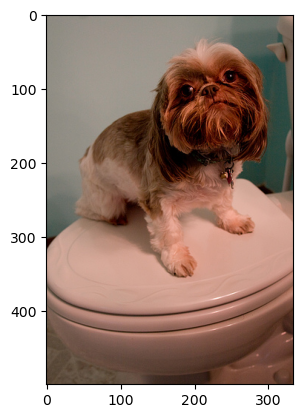

In [ ]:

# Load the image
image_path = "../dataset/000000001622.jpg"
img = Image.open(image_path)

# Create figure and axes
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(img)

# Create a Rectangle patch
segmentation = annotations['segmentation'][0]

In [ ]:
label_color_map = [
        (0, 0, 0),        # Background (black)
        (128, 0, 0),      # Bird (maroon)
        (0, 128, 128),    # Cat (teal)
        (128, 0, 128),    # Dog (purple)
        (170, 110, 40),   # Horse (brown)
        (230, 230, 250),  # Sheep (light purple)
        (189, 183, 107),  # Cow (khaki)
        (192, 192, 192),  # Elephant (silver)
        (255, 140, 0),    # Bear (dark orange)
        (0, 0, 128),      # Zebra (navy)
        (34, 139, 34)     # Giraffe (forest green)
    ]

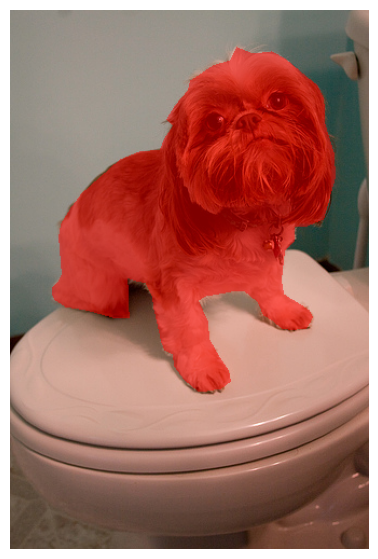

In [17]:
def visualize_segmentation_from_path(image_path, segmentation_points, alpha=0.5, color=(255, 0, 0)):
    """
    Load an image from path and visualize segmentation mask on it.
    
    Args:
        image_path: Path to the image file
        segmentation_points: List of [x, y] coordinates defining the polygon
        alpha: Transparency of the mask (0 to 1)
        color: RGB tuple for mask color
    
    Returns:
        PIL Image with the segmentation overlay
    """
    # Load the image
    image = Image.open(image_path)
    
    # Create a mask image with the same size as the input image
    mask = Image.new('RGBA', image.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(mask)
    
    # Convert the flat list into pairs of coordinates
    polygon_points = []
    for i in range(0, len(segmentation_points), 2):
        polygon_points.append((segmentation_points[i], segmentation_points[i + 1]))
    
    # Draw the polygon on the mask
    draw.polygon(polygon_points, fill=(*color, int(alpha * 255)))
    
    # Convert image to RGBA if it isn't already
    image_rgba = image.convert('RGBA')
    
    # Composite the mask onto the original image
    image_with_mask = Image.alpha_composite(image_rgba, mask)
    
    return image_with_mask


image_path = "../dataset/000000001622.jpg"

result = visualize_segmentation_from_path(
    image_path=image_path,
    segmentation_points=segmentation,
    alpha=0.5,
    color=(255, 0, 0)  # Red color for the mask
)

# Display the result
plt.figure(figsize=(7, 7))
plt.imshow(result)
plt.axis('off')
plt.show()

## Use Resnet50 for single image
tutorial: https://debuggercafe.com/semantic-segmentation-using-pytorch-fcn-resnet/